In [1]:
import pandas as pd
import numpy as np
dirty_data_priora = pd.read_csv('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_List1.csv')

# подготавливаем цифровые данные
priora_only_input = dirty_data_priora[['дата', 'часы в пути', 'минуты в пути', 'пробег', 'средний расход', 
                                       'температура', 'маршрут', 'топливо', 'откуда', 'до куда']]
priora_num = priora_only_input.rename(columns={'часы в пути': 'hours', 'маршрут': 'km', 'минуты в пути':'minutes'})
priora_num['temperature'] = pd.to_numeric(priora_num['температура'].str.replace(',','.'), errors='coerce')
priora_num['path'] = pd.to_numeric(priora_num['km'].str.replace(',','.'), errors='coerce')
priora_num['hrs'] = priora_num.hours + priora_num.minutes/60
priora_num['fuel'] = pd.to_numeric(priora_num['топливо'].str.replace(',','.'), errors='coerce')
priora_num['time_h'] = np.diff(priora_num.hrs, prepend=0)
priora_num['benz'] = np.diff(priora_num.fuel, prepend=0)
priora_num['distance'] = np.diff(priora_num.path, prepend=0)
priora_num['av_speed'] = priora_num.distance / priora_num.time_h
priora_num['rashod'] = 100 * priora_num.benz / priora_num.distance

priora_num.drop(columns=['откуда', 'до куда']).head()

# отфильтровываем неразумные данные и исключаем нечисловые (вспомогательные информационные) колонки
priora_detailsfree = priora_num[['temperature', 'distance', 'time_h', 'benz', 'av_speed', 'rashod']] \
                    .query('distance > 3 & time_h > 0 & rashod < 50')
priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod
2,2.0,32.8,0.633333,2.8,51.789474,8.536585
4,1.0,35.6,0.666667,2.3,53.400000,6.460674
5,24.0,366.2,16.066667,37.2,22.792531,10.158383
6,24.0,5.3,0.083333,0.4,63.600000,7.547170
7,24.0,66.2,1.283333,4.8,51.584416,7.250755


In [2]:
# высчитываем глобальные величины по всей базе
global_sr_ras = 100 * priora_detailsfree.benz.sum() / priora_detailsfree.distance.sum()
global_sr_skor = priora_detailsfree.distance.sum() / priora_detailsfree.time_h.sum()
print(
        'средняя скорось за все время эксплуатации = ', round(global_sr_skor, 2),
        'км/ч, при среднем расходе', round(global_sr_ras, 2), 'л/100км'
     )

средняя скорось за все время эксплуатации =  24.76 км/ч, при среднем расходе 9.82 л/100км


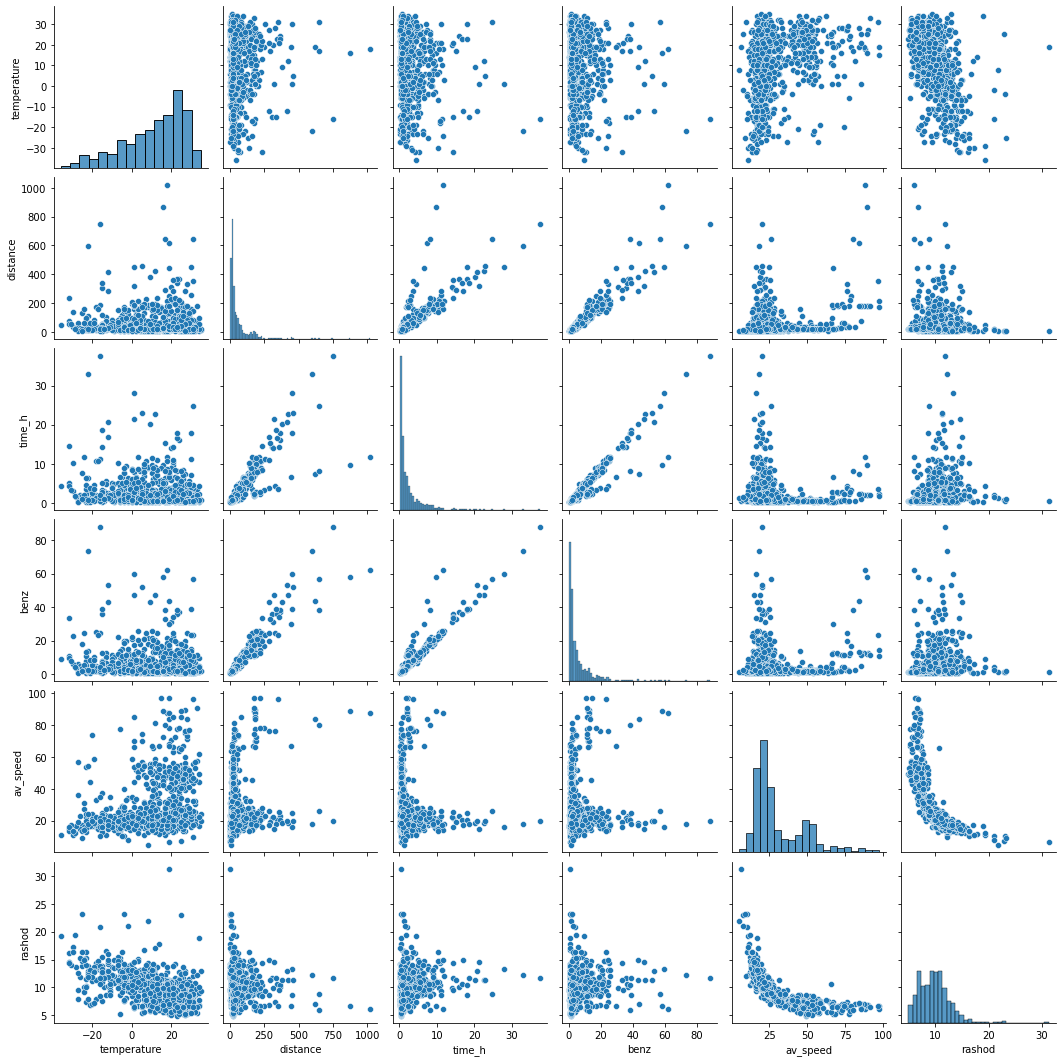

In [3]:
# разведка распределений и корреляций
import seaborn as sns
sns.pairplot(data=priora_detailsfree)

<AxesSubplot:xlabel='time_h', ylabel='benz'>

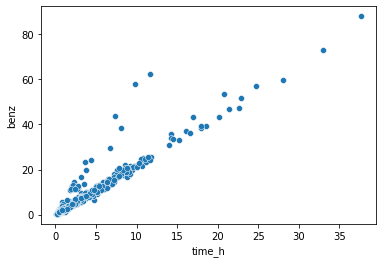

In [4]:
# возьмем бензин в заивсимости от времени. Видно, что основная часть точек подчиняется линейному закону benz = 2*time_h
# Но есть другая ветвь с законом benz = 6*time_h
sns.scatterplot(data=priora_detailsfree, x='time_h', y='benz')

In [7]:
# Возьмеме за разделительную черту benz = 4*time_h
priora_detailsfree['benz_threshold'] = 4*priora_detailsfree.time_h
priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod,benz_threshold
2,2.0,32.8,0.633333,2.8,51.789474,8.536585,2.533333
4,1.0,35.6,0.666667,2.3,53.400000,6.460674,2.666667
5,24.0,366.2,16.066667,37.2,22.792531,10.158383,64.266667
6,24.0,5.3,0.083333,0.4,63.600000,7.547170,0.333333
7,24.0,66.2,1.283333,4.8,51.584416,7.250755,5.133333


In [17]:
# позже будет показано, что зависимость расхода хорошо аппроксимируется прямой в зависимости от 1/скорость
priora_detailsfree['mod_speed'] = np.power(priora_detailsfree.av_speed, -1)
priora_detailsfree['mod_rash'] = np.power(priora_detailsfree.rashod, -1)
priora_detailsfree
# Возьмеме за разделительную черту benz = 4*time_h
priora_detailsfree['benz_threshold'] = 4*priora_detailsfree.time_h
priora_detailsfree
# дадим классификацию normal/anomalous
priora_detailsfree.loc[priora_detailsfree['benz'] <= priora_detailsfree['benz_threshold'], 'check'] = 'normal' 
priora_detailsfree.loc[priora_detailsfree['benz'] > priora_detailsfree['benz_threshold'], 'check'] = 'anomalous'
priora_detailsfree

normal_data = priora_detailsfree.query('check == "normal"')
anomalous_data = priora_detailsfree.query('check == "anomalous"')

Text(0.05, 0.95, '$(1/ras)=0.002\\;V+0.064$\n$R^2 = 0.698$')

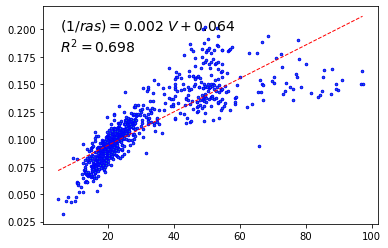

In [34]:
# посроение в координатах (1/rashod) от скорость не лучшим образом отражает зависимость для всех данных
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

x = priora_detailsfree.av_speed
y = priora_detailsfree.mod_rash

plt.plot(x,y,".", ms=5, mec="b")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$(1/ras)={z[0]:0.3f}\;V{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

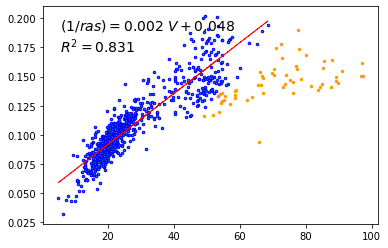

In [35]:
# аппроксимация только нормальных данных дает лучшее согласование с моделью
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

x = normal_data.av_speed
y = normal_data.mod_rash

plt.plot(x,y,".", ms=5, mec="b")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$(1/ras)={z[0]:0.3f}\;V{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')


plt.plot(anomalous_data.av_speed,anomalous_data.mod_rash,".", ms=5, mec="orange")

Text(0.05, 0.95, '$ras=140.241\\;(1/V)+3.856$\n$R^2 = 0.825$')

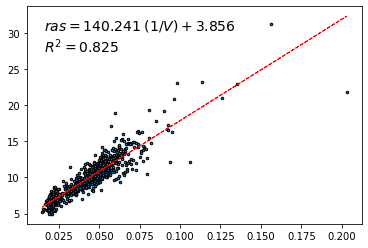

In [27]:
# нормальные данные хорошо подчиняются линейному закону в координатах расход от 1/скорость
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

x = normal_data.mod_speed
y = normal_data.rashod

plt.plot(x,y,".", ms=5, mec="k")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$ras={z[0]:0.3f}\;(1/V){z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

Text(0.05, 0.95, '$ras=190.897\\;(1/V)+4.241$\n$R^2 = 0.358$')

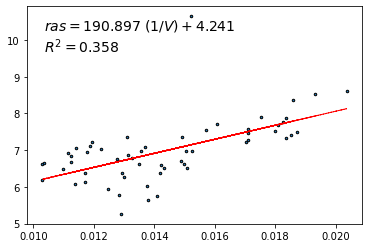

In [16]:
# аномальные данные хуже подчиняются линейному закону
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

x = anomalous_data.mod_speed
y = anomalous_data.rashod

plt.plot(x,y,".", ms=5, mec="k")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$ras={z[0]:0.3f}\;(1/V){z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

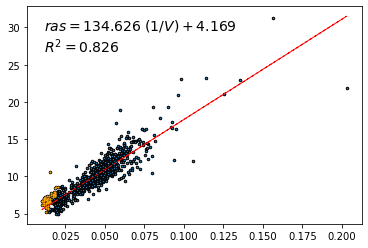

In [21]:
# однако, аномальные данные вписываются в общую картину и не уменьшают коэффициент детерминации в этих координатах
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

x = priora_detailsfree.mod_speed
y = priora_detailsfree.rashod

plt.plot(x,y,".", ms=5, mec="k")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$ras={z[0]:0.3f}\;(1/V){z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.plot(anomalous_data.mod_speed,anomalous_data.rashod,".", ms=2, mec="orange")

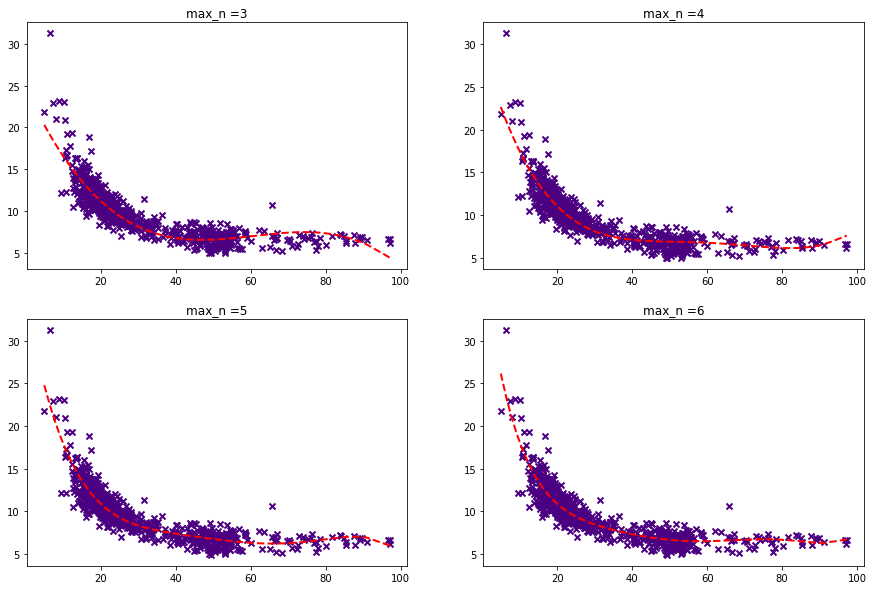

In [109]:
# попробуем сделать аппроксимацию полиномами максимальной степени от 3 до 6
priora_detailsfree = priora_detailsfree.sort_values(by=['av_speed'], axis=0, ascending=True)
#priora_detailsfree.plot.scatter(x='av_speed', y='rashod', c = 'indigo', marker = 'x', linewidth = 2).set(facecolor ='#FFEBCD')
x = priora_detailsfree.av_speed
y = priora_detailsfree.rashod
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
for i in range (3, 7):
    z = np.polyfit(x, y, i)
    p = np.poly1d(z)
    ax = fig.add_subplot(2, 2, i-2)
    ax.scatter(x, priora_detailsfree.rashod, c = 'indigo', marker = 'x', linewidth = 2)
    ax.set(title = 'max_n ='+str(i))
    ax.plot(x,p(x),"r--",  linestyle = '--', linewidth = 2)

plt.show()
# при больших скоростях модель сильно отклоняется при малых степенях, и сильно переобучается при больших степенях

In [2]:
# наилучшая функция регрессии: расход от 1/скорость